In [1]:
import nltk
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from collections import Counter
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix

pd.options.display.max_colwidth = 200

lemmatizer = WordNetLemmatizer()

In [2]:
data = pd.read_csv('./DS2_clean.csv', encoding='utf-8')
data.head()


,text,category,label
0,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...,normal,False
1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!,offensive_language,True
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit,offensive_language,True
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny,offensive_language,True
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;,offensive_language,True


In [3]:
data.describe()
data['label'] = data['label'].apply(lambda label: 0 if label == False else 1)

Percentage of Offensive language: 83.2%


Text(0.5, 1.0, 'Empirical distribution of the labels')

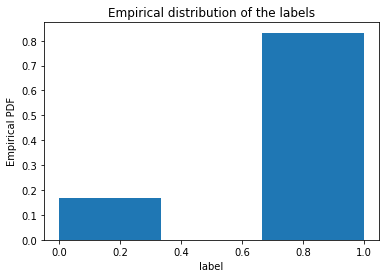

In [4]:
# Empirical distribution of the labels
print('Percentage of Offensive language: {0}%'.format(round(100 * data['label'].sum() / len(data['label']), 2)))
plt.hist(data['label'], bins=3, weights=np.ones(len(data['label'])) / len(data['label']))
plt.xlabel('label')
plt.ylabel('Empirical PDF')
plt.title('Empirical distribution of the labels')

In [5]:
# extract spams and hams
offensive = data['text'].iloc[(data['label'] == 1).values]
normal = data['text'].iloc[(data['label'] == 0).values]
print(offensive[:10])
print(normal[:10])

1                                                                              !!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2                                           !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3                                                                                                     !!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4                          !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;
5     !!!!!!!!!!!!!!!!!!"@T_Madison_x: The shit just blows me..claim you so faithful and down for somebody but still fucking with hoes! &#128514;&#128514;&#128514;"
6                                                          !!!!!!"@__BrighterDays: I can not just sit up and HATE on another bitch .. I got too much shit going on!"
7         

In [6]:
data['text_length'] = data['text'].apply(lambda text: len(text))
data.sort_values(by='text_length', ascending=False)
# most of offensie are long sentences? 


,text,category,label,text_length
17865,RT @TrxllLegend: One good girl is worth a thousand bitches\n\n&#128112; = &#128109;&#128109;&#128109;&#128109;&#128109;&#128109;&#128109;&#128109;&#128109;&#128109;&#128109;&#128109;&#128109;&#128...,offensive_language,1,754
13402,No summer school? &#128515;&#128515;&#128515;&#128515;&#128515;&#128515;&#128515;&#128515;&#128515;&#128515;&#128515;&#128515;&#128515;&#128515;&#128515;&#128515;&#128515;&#128515;&#128515;&#12851...,offensive_language,1,657
1596,&#8220;@Untouchable_T: Never seen so many perfect bitches til I made a Twitter &#128564; but &#128056;&#9749;&#65039;&#8221;&#128175;&#128175;&#128175;&#128175;&#128175;&#128175;&#128175;&#128175;...,offensive_language,1,637
16539,RT @Mr_MshkL: &#1589;&#1608;&#1585;&#1577; &#1604;&#1591;&#1575;&#1574;&#1585; &#1575;&#1604;&#1603;&#1575;&#1585;&#1583;&#1610;&#1606;&#1575;&#1604; &#1575;&#1604;&#1571;&#1581;&#1605;&#1585; &#1...,normal,0,522
18886,RT @digiflorals: bitch do it look like I care \n\n&#12288; N\n&#12288;&#12288; O\n&#12288;&#12288;&#12288; O\n&#12288;&#12288;&#12288;&#12288; o\n&#12288;&#12288;&#12288;&#12288;&#12288;o\n&#12288...,offensive_language,1,455
...,...,...,...,...
8944,Emd hoe,offensive_language,1,7
24619,u a hoe,offensive_language,1,7
24393,retard.,offensive_language,1,7
24364,pussy,offensive_language,1,5


Text(0.5, 1.0, 'Empirical distribution of the message lengths')

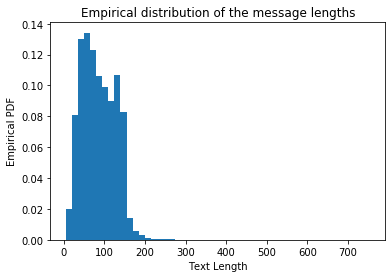

In [7]:
plt.hist(data['text_length'], bins=50, weights=np.ones(len(data))/len(data))
plt.xlabel('Text Length')
plt.ylabel('Empirical PDF')
plt.title('Empirical distribution of the message lengths')

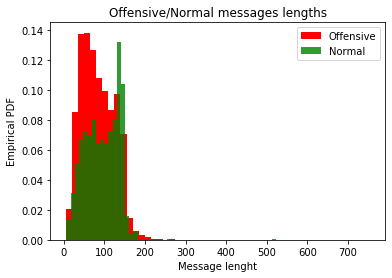

In [8]:
plt.hist(offensive.apply(lambda x: len(x)),
         bins=50,
         weights=np.ones(len(offensive)) / len(offensive),
         facecolor='r',
         label='Offensive')
plt.hist(normal.apply(lambda x: len(x)),
         bins=50,
         weights=np.ones(len(normal)) / len(normal),
         facecolor='g',
         alpha=0.8,
         label='Normal')
plt.xlabel('Message lenght')
plt.ylabel('Empirical PDF')
plt.title('Offensive/Normal messages lengths')
def preprocess(text):
    result = []
    for token in simple_preprocess(text):
        if token not in STOPWORDS and len(token) > 3:
            result.append(lemmatizer.lemmatize(token, pos='v'))
    return " ".join(result).strip()
plt.legend()

In [9]:
def preprocess(text):
    result = []
    for token in simple_preprocess(text):
        if token not in STOPWORDS and len(token) > 3:
            result.append(lemmatizer.lemmatize(token, pos='v'))
    return " ".join(result).strip()

def clean_tweets(df):
    URL = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    MENTION = r'@[A-Za-z0-9_]+'
    RT = r'RT '
    LINE = r'\n'
    AND = r'&amp;'
    TRUNCATED = r'[^\s]+…'
    EMOJI = r'\"\s|\s\"|&#\d+|@[A-Za-z0-9_]+|[:;#.&,!]|http|\d+_\w+'

    pattern_list = [URL, MENTION, LINE, AND, TRUNCATED, EMOJI]

    for i, t in df.items():
        for p in pattern_list:
            pattern = re.compile(p, re.IGNORECASE)
            t = pattern.sub("", t).strip()
        # preprocessing text
        t = preprocess(t)
        df[i] = t

    #return df

clean_tweets(offensive)
clean_tweets(normal)

In [10]:
# most common words in spam and ham
offensive_tokens = []
for word in offensive:
    offensive_tokens += nltk.tokenize.word_tokenize(word)
normal_tokens = []
for word in normal:
    normal_tokens += nltk.tokenize.word_tokenize(word)
print(offensive_tokens[:10])
print(normal_tokens[:10])


['dats', 'coldtyga', 'cuffin', 'place', 'dawg', 'fuck', 'bitch', 'start', 'confuse', 'shit']
['woman', 'shouldn', 'complain', 'clean', 'house', 'trash', 'momma', 'say', 'pussy', 'cat']


In [11]:
most_common_tokens_in_offensive = Counter(offensive_tokens).most_common(20)
most_common_tokens_in_normal = Counter(normal_tokens).most_common(20)
print(most_common_tokens_in_offensive)
print(most_common_tokens_in_normal)

[('bitch', 11148), ('like', 2409), ('hoe', 2324), ('fuck', 2215), ('pussy', 2091), ('shit', 1275), ('nigga', 1199), ('know', 835), ('niggas', 779), ('love', 657), ('want', 632), ('look', 624), ('na', 573), ('think', 561), ('faggot', 528), ('go', 526), ('talk', 515), ('tell', 482), ('need', 468), ('trash', 459)]
[('trash', 688), ('bird', 466), ('like', 305), ('charlie', 255), ('yellow', 219), ('yankees', 217), ('look', 131), ('color', 124), ('think', 116), ('go', 113), ('want', 112), ('monkey', 110), ('know', 107), ('ghetto', 107), ('game', 104), ('love', 99), ('good', 92), ('mock', 89), ('time', 85), ('talk', 81)]


In [12]:
data, test_data = train_test_split(data, test_size=0.3)
print('Train-valid data length: {0}'.format(len(data)))
print('Test data length: {0}'.format(len(test_data)))


Train-valid data length: 17348
Test data length: 7435


In [13]:
binary_vectorizer = CountVectorizer(binary=True)
count_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)

In [14]:
def feature_extraction(df, test=False):
    if not test:
        tfidf_vectorizer.fit(df['text'])
    
    X = np.array(tfidf_vectorizer.transform(df['text']).todense())
    return X


In [15]:
train_df, valid_df = train_test_split(data, test_size=0.3)

X_train = feature_extraction(train_df)
y_train = train_df['label'].values

X_valid = feature_extraction(valid_df, test=True)
y_valid = valid_df['label'].values


In [16]:
tv_matrix = tfidf_vectorizer.fit_transform(train_df['text']).toarray()
vocab = tfidf_vectorizer.get_feature_names()
pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)

,00,000,0000000000000,003,007,007m_h,00_jackie,00am,00pm,00sexilexi00,...,zukwj2ve2d,zulema,zv8zsmhnlm,zvymcxquta,zwithr,zwnbhpdz8e,zxuxfxpzi7,zzachbarness,zzkagxivlu,zzzentropy
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
clfs = {
    'mnb': MultinomialNB(),
    'gnb': GaussianNB(),
    'svm1': SVC(kernel='linear'),
    #'svm2': SVC(kernel='rbf'),
    #'svm3': SVC(kernel='sigmoid'),
    #'mlp1': MLPClassifier(),
    #'mlp2': MLPClassifier(hidden_layer_sizes=[100, 100]),
    'ada': AdaBoostClassifier(),
    'dtc': DecisionTreeClassifier(),
    'rfc': RandomForestClassifier(),
    'gbc': GradientBoostingClassifier(),
    'lr': LogisticRegression()
}

In [ ]:
f1_scores = dict()
for clf_name in clfs:
    print(clf_name)
    clf = clfs[clf_name]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    f1_scores[clf_name] = f1_score(y_pred, y_valid)



mnb
gnb


In [1]:
f1_scores

NameError: name 'f1_scores' is not defined